In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
from skimage import exposure
from scipy import ndimage
import nibabel as nib
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from adjustText import adjust_text

In [2]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
Numpy version: 2.1.0
Matplotlib version: 3.9.2
SITK version: 2.4.0
Scikit-image version: 0.24.0


In [3]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
EVALUATION_DIR = '{}/evaluation'.format(PREPROCESSED_BASE_DIR)

In [4]:
if not os.path.exists(EVALUATION_DIR):
    os.makedirs(EVALUATION_DIR)

In [5]:
DATASET_EVALUATION_FILE = '{}/evaluation-unquantised.pkl'.format(EVALUATION_DIR)

if os.path.isfile(DATASET_EVALUATION_FILE):
    with open(DATASET_EVALUATION_FILE, 'rb') as f:
        dataset_d = pickle.load(f)

In [6]:
print('{: >10}{: >15}{: >15}{: >15}{: >15}'.format('Patient ID','Spearman-Jac','p-value Jac','Spearman-HU','p-value HU'))
for k,v in dataset_d.items():
    print('{: >10}{: >15.2f}{: >15.3f}{: >15.2f}{: >15.3f}'.format(k, v['spearman_correlation_jac'], v['pval_jac'], v['spearman_correlation_hu'], v['pval_hu']))

Patient ID   Spearman-Jac    p-value Jac    Spearman-HU     p-value HU
         1           0.66          0.000           0.65          0.000
         2           0.35          0.000           0.14          0.000
         3           0.32          0.000           0.18          0.000
         4           0.74          0.000           0.59          0.000
         5           0.64          0.000           0.52          0.000
         6           0.64          0.000           0.57          0.000
         7           0.69          0.000           0.42          0.000
         8           0.69          0.000           0.45          0.000
         9           0.69          0.000           0.75          0.000
        10           0.71          0.000           0.77          0.000
        11           0.69          0.000           0.63          0.000
        12           0.66          0.000           0.55          0.000
        13           0.19          0.000           0.37          0.000
      

In [7]:
spearman_dir = []
spearman_dir.append([value['spearman_correlation_jac'] for key, value in dataset_d.items()])
spearman_dir.append([value['spearman_correlation_hu'] for key, value in dataset_d.items()])

In [8]:
print('spearman Jac mean = {:0.2f} ({:0.2f} to {:0.2f})'.format(np.mean(spearman_dir[0]), np.min(spearman_dir[0]), np.max(spearman_dir[0])))
print('spearman HU mean = {:0.2f} ({:0.2f} to {:0.2f})'.format(np.mean(spearman_dir[1]), np.min(spearman_dir[1]), np.max(spearman_dir[1])))

spearman Jac mean = 0.60 (0.19 to 0.77)
spearman HU mean = 0.52 (0.14 to 0.77)


In [9]:
import pandas as pd
rows_l = []
for patient_id in dataset_d.keys():
    patient_d = dataset_d[patient_id]
    for model in ['spearman_correlation_jac','spearman_correlation_hu']:
        d = {'patient_id':patient_id}
        d['model'] = model
        d['spearman'] = patient_d[model]
        rows_l.append(d)
analysis_df = pd.DataFrame(rows_l)

In [10]:
def box_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    series = series[mask]
    return series

In [11]:
params = {}
params['font.size'] = 18
params['figure.dpi'] = 150
params['figure.figsize'] = 4,7

plt.rcParams.update(params)

In [12]:
label_offsets = {'spearman_correlation_jac':-0.15, 'spearman_correlation_hu':0.25}
plot_x = {'spearman_correlation_jac':0, 'spearman_correlation_hu':1}

In [13]:
analysis_df.replace({'model': {'spearman_correlation_jac': 'Jac', 'spearman_correlation_hu': 'HU'}}, inplace=True)

saved figure to /home/daryl/figures/ctvi-dir-spearman-boxplot.png


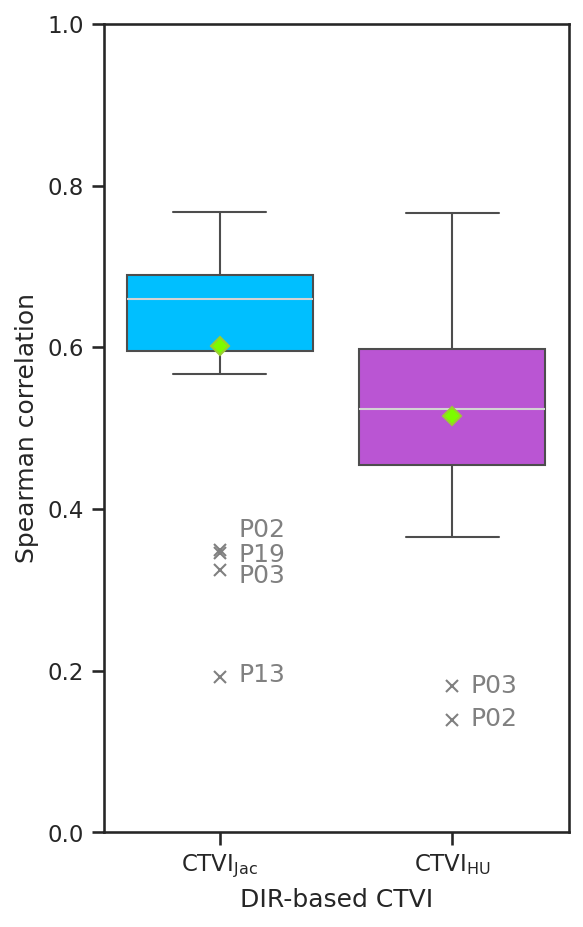

In [14]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

bp = sns.boxplot(x="model", y="spearman",
                 hue="model", palette=['deepskyblue','mediumorchid'], 
                 flierprops=dict(markerfacecolor='lightgrey', marker='x', markeredgecolor='grey'),
                 medianprops={"color": "lightgray", "linewidth": 1}, 
                 meanprops=dict(markerfacecolor='lawngreen', marker='D', markeredgecolor='yellowgreen'),
                 saturation=1.0, 
                 showmeans=True,
                 legend=False,
                 data=analysis_df)

# label the outliers
for model_idx,model in enumerate(['Jac','HU']):
    label_l = []
    df = analysis_df[(analysis_df['model'] == model)]
    outliers = box_outliers(df.spearman)
    for o in outliers:
        patient_id = df.iloc[(df['spearman'] - o).abs().argsort()[:1]].patient_id.iloc[0]
        label_l.append(plt.text(model_idx+0.07, o, 'P{:02d}'.format(patient_id), ha='left', va='center', fontsize=12, color='grey'))
    adjust_text(label_l, only_move={'text':'y?'})

_ = bp.set_xlabel('DIR-based CTVI')
_ = bp.set_ylabel('Spearman correlation')
_ = bp.set_xticks([0, 1])
_ = bp.set_xticklabels([r'CTVI$_\text{Jac}$', r'CTVI$_\text{HU}$'])
_ = bp.set_ylim([0,1])

fig_filename = '{}/figures/ctvi-dir-spearman-boxplot.png'.format(expanduser('~'))
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))

#### remove P02, P03, P19, P20 to match patient cohort from Eslick et al paper

In [15]:
analysis_df = analysis_df.drop(analysis_df[analysis_df['patient_id'] == 2].index)
analysis_df = analysis_df.drop(analysis_df[analysis_df['patient_id'] == 3].index)
analysis_df = analysis_df.drop(analysis_df[analysis_df['patient_id'] == 19].index)
analysis_df = analysis_df.drop(analysis_df[analysis_df['patient_id'] == 20].index)

In [16]:
spearman_jac = analysis_df[analysis_df.model=='Jac']['spearman']
spearman_hu = analysis_df[analysis_df.model=='HU']['spearman']

In [17]:
print('spearman Jac mean = {:0.2f} ({:0.2f} to {:0.2f})'.format(np.mean(spearman_jac), np.min(spearman_jac), np.max(spearman_jac)))
print('spearman HU mean = {:0.2f} ({:0.2f} to {:0.2f})'.format(np.mean(spearman_hu), np.min(spearman_hu), np.max(spearman_hu)))

spearman Jac mean = 0.64 (0.19 to 0.77)
spearman HU mean = 0.55 (0.37 to 0.77)


saved figure to /home/daryl/figures/ctvi-dir-spearman-eslick-boxplot.png


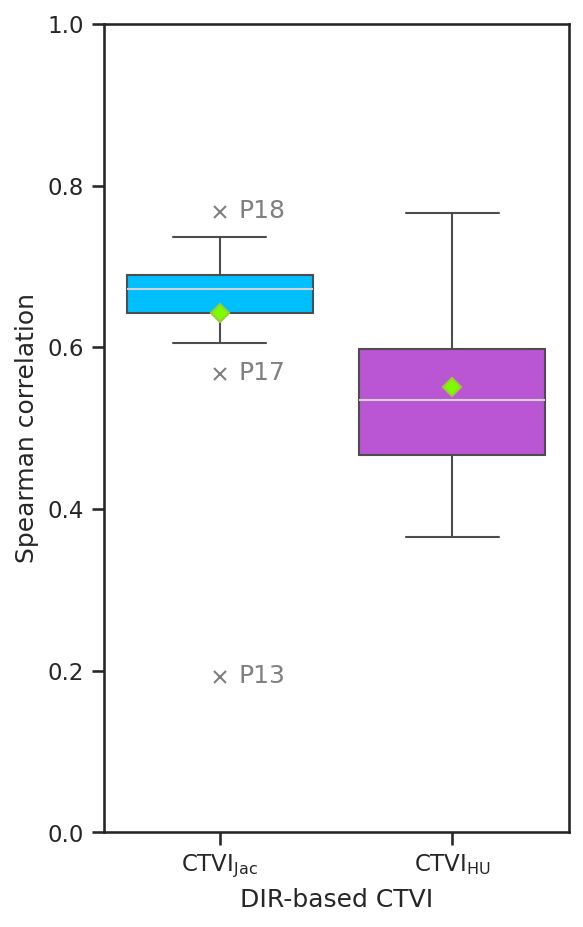

In [18]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

bp = sns.boxplot(x="model", y="spearman",
                 hue="model", palette=['deepskyblue','mediumorchid'], 
                 flierprops=dict(markerfacecolor='lightgrey', marker='x', markeredgecolor='grey'),
                 medianprops={"color": "lightgray", "linewidth": 1}, 
                 meanprops=dict(markerfacecolor='lawngreen', marker='D', markeredgecolor='yellowgreen'),
                 saturation=1.0, 
                 showmeans=True,
                 legend=False,
                 data=analysis_df)

# label the outliers
for model_idx,model in enumerate(['Jac','HU']):
    label_l = []
    df = analysis_df[(analysis_df['model'] == model)]
    outliers = box_outliers(df.spearman)
    for o in outliers:
        patient_id = df.iloc[(df['spearman'] - o).abs().argsort()[:1]].patient_id.iloc[0]
        label_l.append(plt.text(model_idx+0.07, o, 'P{:02d}'.format(patient_id), ha='left', va='center', fontsize=12, color='grey'))
    adjust_text(label_l, only_move={'text':'y?'})

_ = bp.set_xlabel('DIR-based CTVI')
_ = bp.set_ylabel('Spearman correlation')
_ = bp.set_xticks([0, 1])
_ = bp.set_xticklabels([r'CTVI$_\text{Jac}$', r'CTVI$_\text{HU}$'])
_ = bp.set_ylim([0,1])

fig_filename = '{}/figures/ctvi-dir-spearman-eslick-boxplot.png'.format(expanduser('~'))
plt.savefig(fig_filename, format='png', dpi=600, bbox_inches='tight')
print('saved figure to {}'.format(fig_filename))